In [2]:
%matplotlib inline
import pandas as pd 
from Processing import isHoliday
import datetime
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt

In [3]:
input_file = 'data/chilectra.csv'
df = pd.read_csv(input_file)

In [4]:
date_columns = ['year', 'month', 'day', 'hour']
df['dates'] = df[date_columns].apply(lambda s : datetime.datetime(*s),axis = 1)
df["day"] = df["dates"].dt.dayofweek
df["isNewYears"] = isHoliday("New Year's Day", df).astype(int)
df["isLaborDay"] = isHoliday("Labor Day", df).astype(int)
df["isChristmas"] = isHoliday("Christmas Day", df).astype(int)
df["is18"] = isHoliday("Fiestas Patrias", df).astype(int)
df["is19"] = isHoliday("Glorias Ejercito", df).astype(int)
df["is21mayo"] = isHoliday("Glorias navales", df).astype(int)

In [5]:
train = df["load"][:-8760]
test = df["load"][-8760:]
mean, std = train.mean(), train.std()

In [6]:
def data_generator(data, backward, forward, mean, std):
    data = data.values
    N = len(data)
    normalized = ((data - mean)/std)
    targets = TimeseriesGenerator(data, data, length=forward, batch_size=N)
    target, _ = targets[0]
    series = TimeseriesGenerator(normalized[:-forward], target, length=backward, batch_size=N - forward)
    input, output = series[0]
    return input, output

In [9]:
input_train, output_train = data_generator(train, 72, 24, mean, std)
input_test, output_test = data_generator(test, 72, 24, mean, std)
n, m = input_train.shape
input_train = input_train.reshape(n, m, 1)
dropout = 0

In [10]:
input_layer = Input(shape=(m, 1))
seq = LSTM(units=20, dropout=dropout, return_sequences=True)(input_layer)
seq = LSTM(units=20, dropout=dropout)(seq)
seq = Dense(80, activation=tf.nn.relu)(seq)
output_layer = Dropout(dropout)(seq)
output_layer = Dense(24)(output_layer)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam()

model.compile(
        loss="mean_squared_error",
        optimizer=optimizer,
        metrics=["mean_absolute_error", "mean_squared_error"])

In [78]:
checkpoint_name = 'checkpoints/Weights.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, 
                            monitor='val_loss',
                            verbose = 1, 
                            save_best_only = True, 
                            mode ='min')

In [ ]:
history = model.fit(input_train,
                    output_train,
                    epochs=10,
                    validation_split=0.3,
                    verbose=2,
                    callbacks=[checkpoint])

In [11]:
model.load_weights("checkpoints/Weights.hdf5")

model.compile(
    loss="mean_squared_error",
    optimizer=optimizer,
    metrics=["mean_absolute_error", "mean_squared_error"],
)

In [12]:
pred = model.predict(input_train)

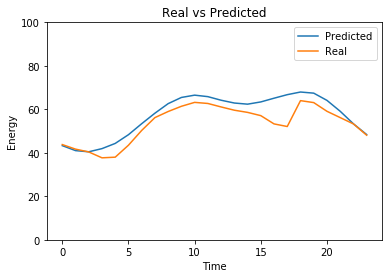

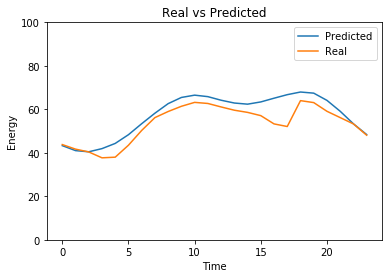

In [15]:
from IPython import display

for i in range(8000, 8500):
    plt.clf()
    plt.plot(pred[i])
    plt.plot(output_train[i])
    plt.title('Real vs Predicted')
    plt.ylabel('Energy')
    plt.ylim(0, 100)
    plt.xlabel('Time')
    plt.legend(['Predicted', 'Real'], loc='upper right')
    display.clear_output(wait=True)
    display.display(plt.gcf())

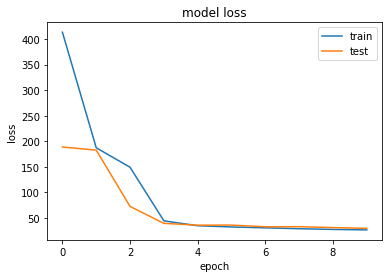

In [66]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()